# MPB field profiles

Setup as before :

In [3]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

In [4]:
# Parameters for the waveguide
w = 0.50  # Si width (um)
h = 0.25  # Si height (um)

# Materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

sc_y = 2  # supercell width (um)
sc_z = 2  # supercell height (um)
resolution = 32  # pixels/um
geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

# define the 2d blocks for the strip and substrate
geometry = [mp.Block(size=mp.Vector3(mp.inf, mp.inf, 0.5 * (sc_z - h)),
                     center=mp.Vector3(z=0.25 * (sc_z + h)), material=SiO2),
            mp.Block(size=mp.Vector3(mp.inf, w, h), material=Si)]

# The k (i.e. beta, i.e. propagation constant) points to look at, in
# units of 2*pi/um.  We'll look at num_k points from k_min to k_max.
num_k = 30
k_min = 0.1
k_max = 3.0
k_points = mp.interpolate(num_k, [mp.Vector3(k_min), mp.Vector3(k_max)])

# Increase this to see more modes.  (The guided ones are the ones below the
# light line, i.e. those with frequencies < kmag / 1.45, where kmag
# is the corresponding column in the output if you grep for "freqs:".)
num_bands = 4

We know how the bands look like, so let's now look at the modes at a given frequency, say $1.55\mu$m. We can proceed inversely : `ms.run()` computes $\omega(k)$, while `ms.find_k` computes $k(\omega)$. Here, we will also pass a mpb.output function to the `run()` function, which will output h5 files. This is useful when what is being output is not a single number like before.

We add the "mpb.output_poynting_x" flag to output the the x-component of the Poynting vector to the file starting with "filename_prefix".

In [5]:
# ModeSolver object
ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    # Add new things pertaining to simulation
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands,
    filename_prefix='03-MPB_fields_data'
)

f_mode = 1/1.55   # frequency corresponding to 1.55 um                                                                                                             
band_min = 1
band_max = 1 # Look at the lowest modes
kdir = mp.Vector3(1)
tol = 1e-6
kmag_guess = f_mode*3.45
kmag_min = f_mode*0.1
kmag_max = f_mode*4.0

k_1p55um = ms.find_k(mp.NO_PARITY, f_mode, band_min, band_max, kdir, tol, kmag_guess,
          kmag_min, kmag_max)

Initializing eigensolver data
Computing 1 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 64 x 64.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 2, 0)
     (0, 0, 2)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 0.5)
Geometric objects:
     block, center = (0,0,0.5625)
          size (1e+20,1e+20,0.875)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1e+20,0.5,0.25)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 8 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<2.2258064516129035, 0.0, 0.0>
elapsed time for initialization: 0.025534629821777344
solve_kpoint (2.22581,0,0):
Solving for bands 1 to 1...
Finished solving for bands 1 to 1 after 18 i

Now that we know the k-vector(s) stored in the the list `k_1p55um`, we can rerun the mode solver to load the desired mode into memory.

## Extracting the fields

There are again many functions to extract the fields from your simulation, see https://mpb.readthedocs.io/en/latest/Python_User_Interface/#field-manipulation. The example https://mpb.readthedocs.io/en/latest/Python_Data_Analysis_Tutorial/#the-source-of-the-tm-gap-examining-the-modes is also useful.

In [24]:
ms.run_te(mpb.output_at_kpoint(mp.Vector3(k_1p55um[0],0,0), mpb.fix_hfield_phase,
          get_hfields))

Initializing eigensolver data
Computing 4 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 64 x 64.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 2, 0)
     (0, 0, 2)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 0.5)
Geometric objects:
     block, center = (0,0,0.5625)
          size (1e+20,1e+20,0.875)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1e+20,0.5,0.25)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 8 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: zeven.
Initializing fields to random numbers...
32 k-points
  Vector3<0.1, 0.0, 0.0>
  Vector3<0.1935483870967742, 0.0, 0.0>
  Vector3<0.2870967741935484, 0.0, 0.0>
  Vector3<0.38064516129032255, 0.0, 0.0>
  Vector3<0.4741935483870968, 0.0, 0.0>
  Vector3<0.56774193548

Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 7 iterations.
zevenfreqs:, 27, 2.53226, 0, 0, 2.53226, 0.885444, 1.02521, 1.21685, 1.35352
elapsed time for k point: 0.03193497657775879
solve_kpoint (2.62581,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 15 iterations.
zevenfreqs:, 28, 2.62581, 0, 0, 2.62581, 0.909788, 1.04617, 1.23486, 1.37189
elapsed time for k point: 0.056073665618896484
solve_kpoint (2.71935,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 10 iterations.
zevenfreqs:, 29, 2.71935, 0, 0, 2.71935, 0.934272, 1.06739, 1.25317, 1.39034
elapsed time for k point: 0.04114389419555664
solve_kpoint (2.8129,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 7 iterations.
zevenfreqs:, 30, 2.8129, 0, 0, 2.8129, 0.958845, 1.08885, 1.27173, 1.40892
elapsed time for k point: 0.03278350830078125
solve_kpoint (2.90645,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 

Finished solving for bands 1 to 4 after 9 iterations.
zevenfreqs:, 19, 1.78387, 0, 0, 1.78387, 0.695994, 0.868015, 1.08149, 1.20116
elapsed time for k point: 0.03778195381164551
solve_kpoint (1.87742,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 18 iterations.
zevenfreqs:, 20, 1.87742, 0, 0, 1.87742, 0.719015, 0.886533, 1.09779, 1.22178
elapsed time for k point: 0.06503462791442871
solve_kpoint (1.97097,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 11 iterations.
zevenfreqs:, 21, 1.97097, 0, 0, 1.97097, 0.742267, 0.905407, 1.11415, 1.24178
elapsed time for k point: 0.0438084602355957
solve_kpoint (2.06452,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 10 iterations.
zevenfreqs:, 22, 2.06452, 0, 0, 2.06452, 0.765706, 0.924584, 1.13069, 1.26091
elapsed time for k point: 0.04090118408203125
solve_kpoint (2.15806,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 17 iterations.
zevenfr

Now the `ms` object has the right mode loaded into memory. We can access it : 

epsilon: 1-11.9025, mean 1.82414, harm. mean 1.35917, 48.6328% > 1, 7.5592% "fill"


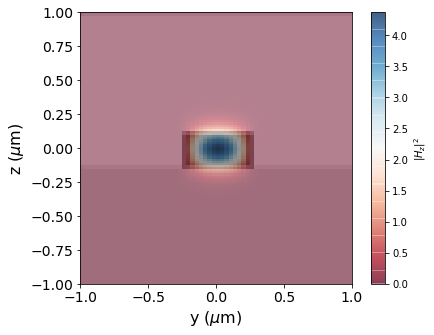

In [39]:
# Get the E or H-field of the i'th band with ms.get_hfield(i),
# and keep only the j'th component with [...,0,j]
f = ms.get_hfield(1)[..., 0, 2] # x-component of field

# Field manipulation object (can recompute with different resolution and other utilities)
md = mpb.MPBData(rectify=True, resolution=64)
f_converted = md.convert(f)
n = np.sqrt(ms.get_epsilon())
n_converted = md.convert(n)

fig, ax = plt.subplots(figsize=(7, 5))

ax.imshow(n.T, cmap='binary', alpha=0.8, extent=[-sc_y/2,sc_y/2,-sc_z/2,sc_z/2])
pos = ax.imshow(np.real(f_converted).T, interpolation='none', cmap='RdBu', alpha=0.5, extent=[-sc_y/2,sc_y/2,-sc_z/2,sc_z/2])
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('$|H_z|^2$')
#ax.axis('off')

ax.set_xlabel('y ($\mu$m)', fontsize=16)
ax.set_ylabel('z ($\mu$m)', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

There are many other ways to do this involving saving fields to files as the first solve happens. MPB's documentation and examples can help you.